In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch-scatter
!pip install torch-sparse
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

In [4]:
users_df = pd.read_csv('/content/drive/MyDrive/data/users_neighborhood_anon.csv')
edges_df = pd.read_csv('/content/drive/MyDrive/data/users.edges')
G = nx.read_graphml('/content/drive/MyDrive/data/users_clean.graphml')

In [5]:
users_df.head()

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,1,other,False,False,2352,19609,309,61,197,0.000000,...,0.000802,0.004465,0.000444,0.001632,0.001298,0.002183,0.008969,0.004975,0.000647,0.003419
2,2,other,False,False,1044,2371,2246,561,16,4897.117853,...,0.000985,0.005284,0.000554,0.001084,0.001359,0.002041,0.016846,0.004881,0.001214,0.003347
3,3,other,False,False,167172,3004,298,3242,53,9.864754,...,0.001391,0.002061,0.001116,0.001282,0.000000,0.001951,0.015423,0.000446,0.000446,0.005241
4,4,other,False,False,1998,17643,19355,485,239,0.000000,...,0.000633,0.035382,0.000317,0.000475,0.000475,0.002431,0.007656,0.033273,0.072792,0.003698


In [6]:
print(users_df.shape)

(100386, 1039)


In [7]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100386 entries, 0 to 100385
Columns: 1039 entries, user_id to c_power_empath
dtypes: bool(6), float64(1025), int64(6), object(2)
memory usage: 791.7+ MB


In [8]:
users_df.isnull().sum()

user_id                 0
hate                    0
hate_neigh              0
normal_neigh            0
statuses_count          0
                     ... 
c_shopping_empath    4008
c_ship_empath        4008
c_religion_empath    4008
c_tourism_empath     4008
c_power_empath       4008
Length: 1039, dtype: int64

In [9]:
# Drop rows with missing values
users_df.dropna(inplace=True)
users_df.head(5)

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,1,other,False,False,2352,19609,309,61,197,0.000000,...,0.000802,0.004465,0.000444,0.001632,0.001298,0.002183,0.008969,0.004975,0.000647,0.003419
2,2,other,False,False,1044,2371,2246,561,16,4897.117853,...,0.000985,0.005284,0.000554,0.001084,0.001359,0.002041,0.016846,0.004881,0.001214,0.003347
3,3,other,False,False,167172,3004,298,3242,53,9.864754,...,0.001391,0.002061,0.001116,0.001282,0.000000,0.001951,0.015423,0.000446,0.000446,0.005241
4,4,other,False,False,1998,17643,19355,485,239,0.000000,...,0.000633,0.035382,0.000317,0.000475,0.000475,0.002431,0.007656,0.033273,0.072792,0.003698


In [10]:
users_df.isnull().sum()

user_id              0
hate                 0
hate_neigh           0
normal_neigh         0
statuses_count       0
                    ..
c_shopping_empath    0
c_ship_empath        0
c_religion_empath    0
c_tourism_empath     0
c_power_empath       0
Length: 1039, dtype: int64

In [11]:
chunk_size = 100
for i in range(0, len(users_df.columns), chunk_size):
    print(users_df.columns[i:i+chunk_size])

Index(['user_id', 'hate', 'hate_neigh', 'normal_neigh', 'statuses_count',
       'followers_count', 'followees_count', 'favorites_count', 'listed_count',
       'betweenness', 'eigenvector', 'in_degree', 'out_degree',
       'negotiate_empath', 'vehicle_empath', 'science_empath',
       'timidity_empath', 'gain_empath', 'swearing_terms_empath',
       'office_empath', 'tourism_empath', 'computer_empath', 'violence_empath',
       'horror_empath', 'dispute_empath', 'sadness_empath', 'internet_empath',
       'college_empath', 'attractive_empath', 'plant_empath',
       'technology_empath', 'reading_empath', 'deception_empath',
       'ancient_empath', 'ship_empath', 'messaging_empath', 'surprise_empath',
       'occupation_empath', 'hearing_empath', 'furniture_empath',
       'restaurant_empath', 'domestic_work_empath', 'art_empath', 'pet_empath',
       'air_travel_empath', 'dance_empath', 'healing_empath', 'smell_empath',
       'sympathy_empath', 'anger_empath', 'neglect_empath', 'fa

In [12]:
# Data preprocessing
columns_to_keep = ['user_id', 'hate', 'hate_neigh', 'normal_neigh','statuses_count',
       'followers_count', 'followees_count', 'favorites_count', 'listed_count',
       'betweenness', 'eigenvector', 'in_degree', 'out_degree', 'retweet number',
       'baddies', 'mentions', 'time_diff', 'time_diff_median', 'created_at',
       'c_statuses_count', 'c_followers_count', 'c_followees_count',
       'c_favorites_count', 'c_listed_count', 'c_time_diff',
       'c_time_diff_median', 'c_betweenness', 'c_number hashtags',
       'c_tweet number', 'c_baddies', 'c_mentions']

# Keep only the specified columns
users_df = users_df[columns_to_keep]

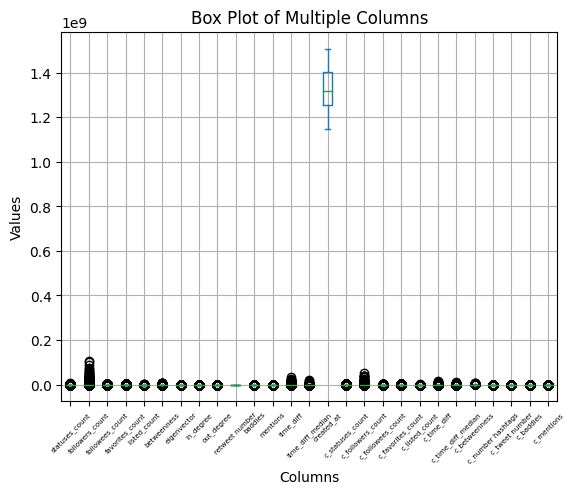

In [13]:
import matplotlib.pyplot as plt
# Assuming 'users_df' is your DataFrame containing the data
columns_to_plot = ['statuses_count',
       'followers_count', 'followees_count', 'favorites_count', 'listed_count',
       'betweenness', 'eigenvector', 'in_degree', 'out_degree', 'retweet number',
       'baddies', 'mentions', 'time_diff', 'time_diff_median', 'created_at',
       'c_statuses_count', 'c_followers_count', 'c_followees_count',
       'c_favorites_count', 'c_listed_count', 'c_time_diff',
       'c_time_diff_median', 'c_betweenness', 'c_number hashtags',
       'c_tweet number', 'c_baddies', 'c_mentions']  # Add more columns as needed

# Create the box plot
boxplot = users_df[columns_to_plot].plot.box(grid=True)

# Rotate the x-axis labels by 45 degrees
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, size=5.0)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot of Multiple Columns')

# Show the plot
plt.show()

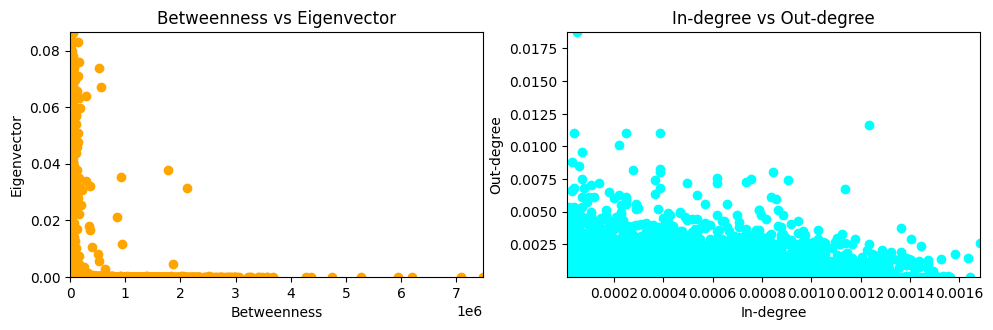

In [14]:
import matplotlib.pyplot as plt

# Assuming 'users_df' is your DataFrame containing the data
# Assuming you have columns 'betweenness', 'eigenvalue', 'in_degree', and 'out_degree'

# Calculate the ranges for x and y axes
x_min = min(users_df['betweenness'])
x_max = max(users_df['betweenness'])
y_min = min(users_df['eigenvector'])
y_max = max(users_df['eigenvector'])

plt.figure(figsize=(10, 6))

# Plot betweenness vs eigenvalue
plt.subplot(2, 2, 1)
plt.scatter(users_df['betweenness'], users_df['eigenvector'], color='orange')
plt.xlabel('Betweenness')
plt.ylabel('Eigenvector')
plt.title('Betweenness vs Eigenvector')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Calculate the ranges for in-degree and out-degree
in_min = min(users_df['in_degree'])
in_max = max(users_df['in_degree'])
out_min = min(users_df['out_degree'])
out_max = max(users_df['out_degree'])

# Plot in-degree vs out-degree
plt.subplot(2, 2, 2)
plt.scatter(users_df['in_degree'], users_df['out_degree'], color='cyan')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.title('In-degree vs Out-degree')
plt.xlim(in_min, in_max)
plt.ylim(out_min, out_max)

plt.tight_layout()
plt.show()


In [15]:
mapping = {'hateful': 0, 'normal': 1, 'other': 2}

# Apply the mapping to the 'hate' column
users_df['hate'] = users_df['hate'].map(mapping)

In [16]:
print(users_df)

        user_id  hate  hate_neigh  normal_neigh  statuses_count  \
0             0     1        True          True          101767   
1             1     2       False         False            2352   
2             2     2       False         False            1044   
3             3     2       False         False          167172   
4             4     2       False         False            1998   
...         ...   ...         ...           ...             ...   
100381   100381     2       False         False            6425   
100382   100382     2       False          True           16928   
100383   100383     2       False         False            1118   
100384   100384     2       False         False            3359   
100385   100385     1       False          True            6868   

        followers_count  followees_count  favorites_count  listed_count  \
0                  3504             3673            81635            53   
1                 19609              309     

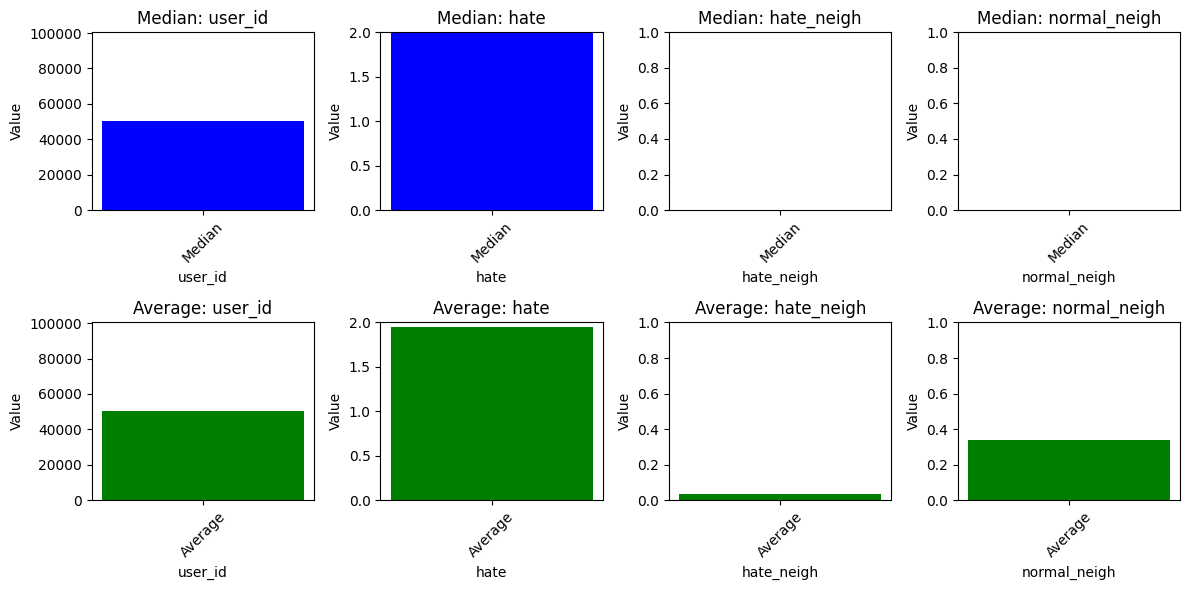

In [17]:
import matplotlib.pyplot as plt

# Assuming 'users_df' is your DataFrame containing the data
# Assuming you want to plot median and average values for 'user_id', 'hate', 'hate_neigh', 'normal_neigh'

# Calculate median and average values for the specified columns
specified_cols = ['user_id', 'hate', 'hate_neigh', 'normal_neigh']
median_values = users_df[specified_cols].median()
average_values = users_df[specified_cols].mean()

# Define custom ranges for each metric (you can adjust these as needed)
custom_ranges = {
    col: (users_df[col].min(), users_df[col].max()) for col in specified_cols
}

# Plot median values for each metric
plt.figure(figsize=(12, 6))
for i, col in enumerate(specified_cols):
    plt.subplot(2, len(specified_cols), i+1)
    plt.bar(['Median'], [median_values[col]], color='blue')
    plt.xlabel(col)
    plt.ylabel('Value')
    plt.title('Median: {}'.format(col))
    plt.xticks(rotation=45)
    plt.ylim(custom_ranges[col])

# Plot average values for each metric
for i, col in enumerate(specified_cols):
    plt.subplot(2, len(specified_cols), i+1+len(specified_cols))
    plt.bar(['Average'], [average_values[col]], color='green')
    plt.xlabel(col)
    plt.ylabel('Value')
    plt.title('Average: {}'.format(col))
    plt.xticks(rotation=45)
    plt.ylim(custom_ranges[col])

plt.tight_layout()
plt.show()


In [18]:
# Extract features and target
X = users_df.drop(columns=['hate'])
y = users_df['hate']

In [19]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classifier Results:")
print(f'Accuracy: {accuracy_rf:.4f}')
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
Accuracy: 0.9532
              precision    recall  f1-score   support

           0       0.79      0.16      0.27        93
           1       0.75      0.10      0.18       849
           2       0.95      1.00      0.98     17613

    accuracy                           0.95     18555
   macro avg       0.83      0.42      0.48     18555
weighted avg       0.94      0.95      0.94     18555



In [22]:
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Support Vector Machine (SVM) classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Support Vector Machine Classifier Results:")
print(f'Accuracy: {accuracy_svm:.4f}')
print(classification_report(y_test, y_pred_svm))

Support Vector Machine Classifier Results:
Accuracy: 0.9492
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.00      0.00      0.00       849
           2       0.95      1.00      0.97     17613

    accuracy                           0.95     18555
   macro avg       0.32      0.33      0.32     18555
weighted avg       0.90      0.95      0.92     18555



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)
y_pred_linear = linear_regressor.predict(X_test_scaled)

In [24]:
# Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train)
y_pred_nb = nb_classifier.predict(X_test_scaled)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Classifier Results:")
print(f'Accuracy: {accuracy_nb:.4f}')
print(classification_report(y_test, y_pred_nb))

Naive Bayes Classifier Results:
Accuracy: 0.7127
              precision    recall  f1-score   support

           0       0.15      0.90      0.25        93
           1       0.14      0.89      0.23       849
           2       1.00      0.70      0.82     17613

    accuracy                           0.71     18555
   macro avg       0.43      0.83      0.44     18555
weighted avg       0.95      0.71      0.80     18555



In [25]:
# K-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_train)
y_pred_knn = knn_classifier.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("K-Nearest Neighbors Classifier Results:")
print(f'Accuracy: {accuracy_knn:.4f}')
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors Classifier Results:
Accuracy: 0.9448
              precision    recall  f1-score   support

           0       0.37      0.35      0.36        93
           1       0.29      0.08      0.12       849
           2       0.96      0.99      0.97     17613

    accuracy                           0.94     18555
   macro avg       0.54      0.47      0.48     18555
weighted avg       0.92      0.94      0.93     18555



In [43]:
# Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_scaled, y_train)
y_pred_dt = dt_classifier.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Classifier Results:")
print(f'Accuracy: {accuracy_dt:.4f}')
print(classification_report(y_test, y_pred_dt))




Decision Tree Classifier Results:
Accuracy: 0.9203
              precision    recall  f1-score   support

           0       0.28      0.29      0.29        93
           1       0.23      0.28      0.25       849
           2       0.96      0.95      0.96     17613

    accuracy                           0.92     18555
   macro avg       0.49      0.51      0.50     18555
weighted avg       0.93      0.92      0.92     18555



In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report

In [28]:
# Convert to PyTorch tensors
train_features = torch.tensor(X_train_scaled, dtype=torch.float)
test_features = torch.tensor(X_test_scaled, dtype=torch.float)
train_labels = torch.tensor(y_train, dtype=torch.long)
y_test_array = y_test.values
test_labels = torch.tensor(y_test_array, dtype=torch.long)

In [29]:
# Edge index for a simple chain graph
edge_index = torch.tensor([[i, i + 1] for i in range(30)], dtype=torch.long).t().contiguous()

In [30]:
# Mask creation for training and testing
num_nodes = train_features.size(0)  # Total number of nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

In [31]:
# Randomly selecting 80% of the indices for training
perm = torch.randperm(num_nodes)
train_indices = perm[:int(0.8 * num_nodes)]
test_indices = perm[int(0.8 * num_nodes):]

In [32]:
train_mask[train_indices] = True
test_mask[test_indices] = True

In [33]:
# Creating the data objects
data = Data(x=train_features, edge_index=edge_index, y=train_labels, test_mask=test_mask)
data.train_mask = train_mask
data.test_mask = test_mask

In [34]:
# GCN Model Definition
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 30)  # First GCN layer
        self.conv2 = GCNConv(30, num_classes)  # Second GCN layer to output class scores

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [35]:
# Initializing the model
model = GCN(num_features=30, num_classes=3)
class_counts = torch.bincount(data.y[data.train_mask])
class_weights = 1.0 / class_counts.float()  # Convert to float for precise division
class_weights /= class_weights.sum()  # Normalize the weights

In [36]:
print(class_weights)

tensor([0.8931, 0.1021, 0.0048])


In [37]:
# Using the calculated class weights in the loss function
criterion = torch.nn.NLLLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [38]:
# Training Function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [40]:
# Training and generating report
for epoch in range(80):
  loss = train()  # Optionally reduce frequency of reporting
  accuracy, report, cm= test_and_report()
print(f'Loss: {loss.item()}, Test Accuracy: {accuracy}')
print(report)

Loss: 0.37479496002197266, Test Accuracy: 0.7305308542171921
              precision    recall  f1-score   support

     Class 0       0.13      0.97      0.22        63
     Class 1       0.15      0.89      0.25       691
     Class 2       1.00      0.72      0.84     14090

    accuracy                           0.73     14844
   macro avg       0.42      0.86      0.44     14844
weighted avg       0.95      0.73      0.81     14844



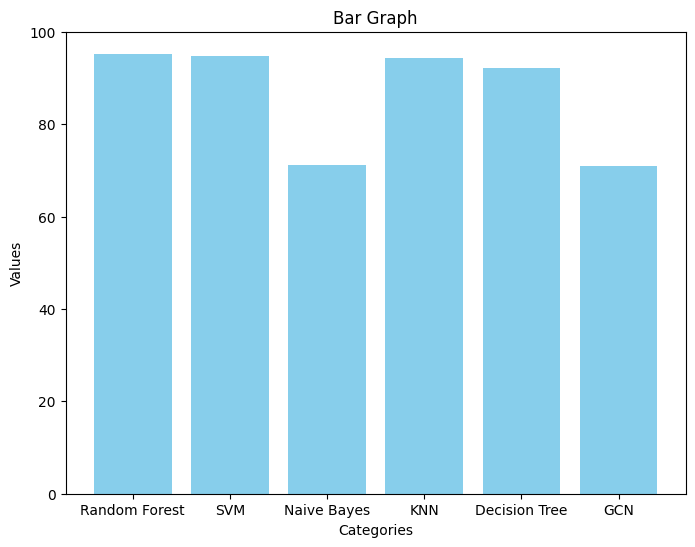

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Random Forest', 'SVM', 'Naive Bayes', 'KNN', 'Decision Tree', 'GCN']
values = [95.3, 94.9, 71.2, 94.4, 92.1, 71.0]

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Graph')
plt.show()
